In [1]:
pip install imblearn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE, ADASYN
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")
# === 1. Load data ===

df = pd.read_excel("Data_Set_(A+B).xlsx")
df_test = pd.read_excel("Data_Set_C.xlsx")


df['Type'] = df['Type'].apply(lambda x: 1 if x == 4 else 0)
df_test['Type'] = df_test['Type'].apply(lambda x: 1 if x == 4 else 0)

In [3]:
def exploratory_data_analysis(train_data, test_data):
    """执行探索性数据分析（EDA）"""
    print("\n=== 探索性数据分析（EDA）===")
    # 1.1 数据概览
    print("\n训练集数据信息：")
    print(train_data.info())
    print(f"训练集形状：{train_data.shape}")
    print("训练集缺失值统计：")
    print(train_data.isnull().sum())

    print("\n测试集数据信息：")
    print(test_data.info())
    print(f"测试集形状：{test_data.shape}")
    print("测试集缺失值统计：")
    print(test_data.isnull().sum())



    print("\n训练集类别分布：")
    print(train_data['Type'].value_counts())


exploratory_data_analysis(df, df_test)


=== 探索性数据分析（EDA）===

训练集数据信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   I1      176 non-null    float64
 1   I2      176 non-null    float64
 2   I3      176 non-null    float64
 3   gx      176 non-null    float64
 4   gy      176 non-null    float64
 5   gz      176 non-null    float64
 6   ax      176 non-null    float64
 7   ay      176 non-null    float64
 8   az      176 non-null    float64
 9   V1real  176 non-null    float64
 10  V2real  176 non-null    float64
 11  V3real  176 non-null    float64
 12  N1      176 non-null    int64  
 13  N2      176 non-null    int64  
 14  N3      176 non-null    int64  
 15  Type    176 non-null    int64  
dtypes: float64(12), int64(4)
memory usage: 22.1 KB
None
训练集形状：(176, 16)
训练集缺失值统计：
I1        0
I2        0
I3        0
gx        0
gy        0
gz        0
ax        0
ay        0
az        0
V1real 

In [4]:
def calculate_v3_features(df):
    N1 = df['N1'].values
    N2 = df['N2'].values
    N3 = df['N3'].values
    I1 = df['I1'].values
    I2 = df['I2'].values
    I3 = df['I3'].values
    gx = df['gx'].values
    gy = df['gy'].values
    gz = df['gz'].values
    ax = df['ax'].values
    ay = df['ay'].values
    az = df['az'].values
    L = 0.2
    r = 0.05
    alpha = 2 * np.pi / 3
    m = 10.0
    I = 0.2
    g = 9.81
    omega1 = (2 * np.pi * N1) / 60
    omega2 = (2 * np.pi * N2) / 60
    omega3 = (2 * np.pi * N3) / 60
    Vx_b = (2/3) * r * (omega1 + omega2 * np.cos(alpha) + omega3 * np.cos(alpha))
    Vy_b = (2/3) * r * (omega2 * np.sin(alpha) - omega3 * np.sin(alpha))
    Omega = (r / (3 * L)) * (omega1 + omega2 + omega3)
    theta = np.arctan2(gy, gx)
    Vx = Vx_b * np.cos(theta) - Vy_b * np.sin(theta)
    Vy = Vx_b * np.sin(theta) + Vy_b * np.cos(theta)
    Ix = (2/3) * (I1 + I2 * np.cos(alpha) + I3 * np.cos(alpha))
    Iy = (2/3) * (I2 * np.sin(alpha) - I3 * np.sin(alpha))
    I_phi = (1 / (3 * L)) * (I1 + I2 + I3)
    I_sigma = I1 + I2 + I3
    dt = 0.1
    dVx = np.zeros_like(Vx)
    dVy = np.zeros_like(Vy)
    dOmega = np.zeros_like(Omega)
    dVx[1:-1] = (Vx[2:] - Vx[:-2]) / (2 * dt)
    dVy[1:-1] = (Vy[2:] - Vy[:-2]) / (2 * dt)
    dOmega[1:-1] = (Omega[2:] - Omega[:-2]) / (2 * dt)
    dVx[0] = (Vx[1] - Vx[0]) / dt
    dVx[-1] = (Vx[-1] - Vx[-2]) / dt
    dVy[0] = (Vy[1] - Vy[0]) / dt
    dVy[-1] = (Vy[-1] - Vy[-2]) / dt
    dOmega[0] = (Omega[1] - Omega[0]) / dt
    dOmega[-1] = (Omega[-1] - Omega[-2]) / dt
    P_trans = m * (Vx * dVx + Vy * dVy)
    P_rot = I * Omega * dOmega
    Fx = m * dVx
    Fy = m * dVy
    F_total = np.sqrt(Fx**2 + Fy**2)
    N = m * g
    mu_est = np.clip(F_total / N, 0, 1)
    v3_features = pd.DataFrame({
        'Vx': Vx,
        'Vy': Vy,
        'Omega': Omega,
        'Ix': Ix,
        'Iy': Iy,
        'I_phi': I_phi,
        'I_sigma': I_sigma,
        'dVx': dVx,
        'dVy': dVy,
        'dOmega': dOmega,
        'P_trans': P_trans,
        'P_rot': P_rot,
        'mu_est': mu_est
    })
    return v3_features

X = calculate_v3_features(df)
X_test = calculate_v3_features(df_test)
Y = df['Type']
Y_test = df_test['Type']
train_data = X.copy()
train_data['Type'] = Y.values
train_data_sorted = train_data.sort_values(by='Type').reset_index(drop=True)
X_sorted = train_data_sorted.drop(columns='Type')
Y_sorted = train_data_sorted['Type']

# 可选：显示前几行检查
print("X 特征维度：", X.shape)
print("y 标签分布：\n", Y.value_counts())
X.head()

X 特征维度： (176, 13)
y 标签分布：
 0    140
1     36
Name: Type, dtype: int64


,Vx,Vy,Omega,Ix,Iy,I_phi,I_sigma,dVx,dVy,dOmega,P_trans,P_rot,mu_est
0,-30.611052,-5.848126,1.736603,0.434892,-0.523359,3.459024,2.075414,253.166998,-260.958211,-11.955505,-62235.917413,-4.152392,1.0
1,-5.294352,-31.943947,0.541052,0.370035,-0.541647,3.345901,2.007541,42.698934,-65.325310,-10.297443,18606.850140,-1.114291,1.0
2,-22.071265,-18.913188,-0.322886,0.290096,-0.544259,3.104576,1.862746,153.631166,85.484898,-7.810348,-50076.261004,0.504370,1.0
3,25.431881,-14.846967,-1.021018,-0.107591,0.350067,3.999497,2.399698,199.120756,-29.247001,0.916298,54982.446540,-0.187111,1.0
4,17.752886,-24.762588,-0.139626,-0.139769,0.329169,3.345904,2.007542,22.871388,105.327948,-2.443461,-22021.594057,0.068234,1.0


Fitting 4 folds for each of 54 candidates, totalling 216 fits
Best F1 Score: 0.3477
Best Model Configuration:
   activation: relu
   hidden_layer_sizes: (128, 64)
   max_iter: 300
   random_state: 42
   solver: sgd
Average Accuracy (Cross-validation): 0.25


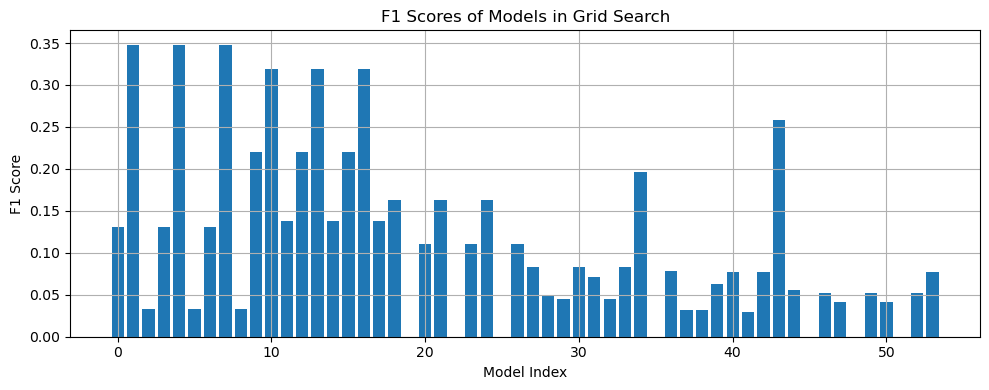

In [5]:
# -------------------------------
# 3. Achieve High Accuracy: Grid Search for Optimizing Neural Network Architecture
# -------------------------------
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import make_scorer, accuracy_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt

# Define the grid search parameters
param_grid = {
    'hidden_layer_sizes': [(128, 64), (64, 32), (32, 16)],
    'activation': ['relu', 'tanh', ],
    'solver': ['adam', 'sgd','lbfgs'],
    'max_iter': [300, 200, 100],
    'random_state': [42]
}

# Initialize the model
clf = MLPClassifier()

# Use 4-fold stratified cross-validation
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Perform grid search with F1 score as the evaluation metric
grid_search = GridSearchCV(
    clf,
    param_grid,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Execute the grid search
grid_search.fit(X, Y)

# Output the best model parameters and F1 score
print(f"Best F1 Score: {round(grid_search.best_score_, 4)}")
print("Best Model Configuration:")
for param, value in grid_search.best_params_.items():
    print(f"   {param}: {value}")

# Calculate accuracy using the best model
best_model = grid_search.best_estimator_
acc_scores = cross_val_score(best_model, X, Y, cv=cv, scoring='accuracy')

print(f"Average Accuracy (Cross-validation): {round(acc_scores.mean(), 4)}")

# Plot model index vs. F1 score
results_df = pd.DataFrame(grid_search.cv_results_)

plt.figure(figsize=(10, 4))
plt.bar(range(len(results_df['mean_test_score'])), results_df['mean_test_score'])

plt.title("F1 Scores of Models in Grid Search")
plt.ylabel("F1 Score")
plt.xlabel("Model Index")
plt.grid(True)
plt.tight_layout()
plt.show()



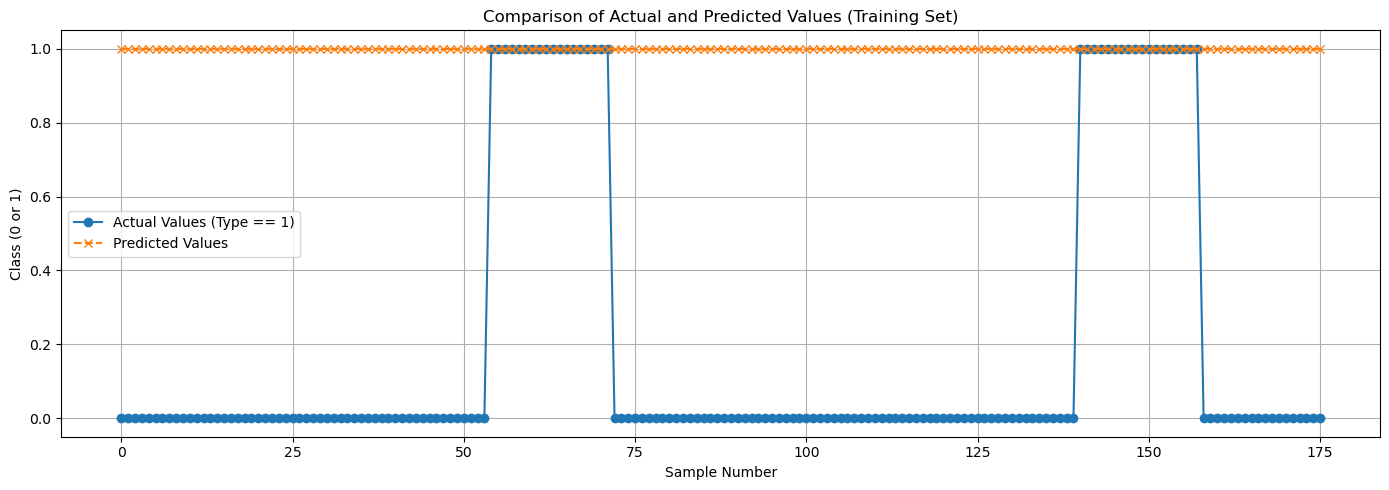

In [6]:
# Fit and predict using the best model (e.g., best_model)
best_model.fit(X, Y)              # Train the model
Y_pred = best_model.predict(X)   # Predict on the training data

# Get the total number of samples
N = len(Y)

# Plot to compare actual values and predicted values
plt.figure(figsize=(14, 5))

# Actual values (blue dots)
plt.plot(np.arange(N), Y[:N], label='Actual Values (Type == 1)', marker='o')

# Predicted values (orange crosses)
plt.plot(np.arange(N), Y_pred[:N], label='Predicted Values', marker='x', linestyle='--')

# Plot settings (all labels in English)
plt.title('Comparison of Actual and Predicted Values (Training Set)')
plt.xlabel('Sample Number')
plt.ylabel('Class (0 or 1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Training on sorted data
Fitting 4 folds for each of 54 candidates, totalling 216 fits
Training on sorted data completed.
Best F1 Score: 0.3553
Best model parameters:
   activation: relu
   hidden_layer_sizes: (64, 32)
   max_iter: 300
   random_state: 42
   solver: sgd
Average Accuracy (cross-validation) on sorted data: 0.3125


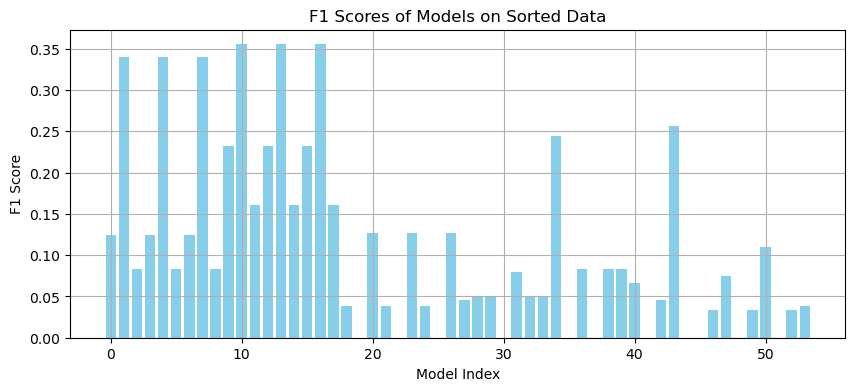

In [7]:
# === 5. Training on sorted data ===
print("# Training on sorted data")

train_data = X.copy()
train_data['Type'] = Y.values  # Add the label column

# Sort by 'Type' in ascending order
train_data_sorted = train_data.sort_values(by='Type').reset_index(drop=True)

# Separate the sorted X and Y
X_sorted = train_data_sorted.drop(columns='Type')
Y_sorted = train_data_sorted['Type']


# -------------------------------
# Using GridSearchCV for parameter search and outputting Accuracy
# -------------------------------
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import pandas as pd

param_grid = {
    'hidden_layer_sizes': [(128, 64), (64, 32), (32, 16)],
    'activation': ['relu', 'tanh', ],
    'solver': ['adam', 'sgd','lbfgs'],
    'max_iter': [300, 200, 100],
    'random_state': [42]
}

# Initialize the model and cross-validation object
clf = MLPClassifier()
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Perform grid search with F1 scoring
grid_search = GridSearchCV(clf, param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_sorted, Y_sorted)

# Output the best parameters and F1 score
print("Training on sorted data completed.")
print("Best F1 Score:", round(grid_search.best_score_, 4))
print("Best model parameters:")
for k, v in grid_search.best_params_.items():
    print(f"   {k}: {v}")

# Calculate the average accuracy using the best model and cross-validation
best_model = grid_search.best_estimator_
accuracy_scores = cross_val_score(best_model,X_sorted, Y_sorted, cv=cv, scoring='accuracy')
print("Average Accuracy (cross-validation) on sorted data:", round(accuracy_scores.mean(), 4))

# Visualize the F1 scores of different models
results = pd.DataFrame(grid_search.cv_results_)

plt.figure(figsize=(10, 4))
plt.bar(range(len(results['mean_test_score'])), results['mean_test_score'], color='skyblue')

plt.title("F1 Scores of Models on Sorted Data")
plt.ylabel("F1 Score")
plt.xlabel("Model Index")
plt.grid(True)
plt.show()

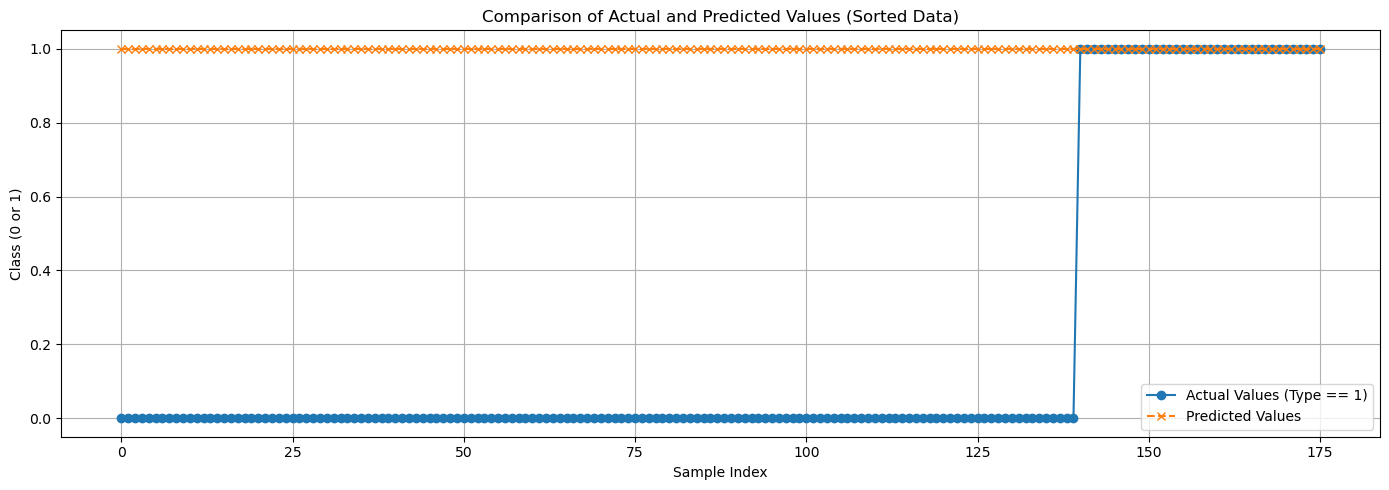

In [8]:
# Fit and predict using the best model from sorted data
best_model_sort = grid_search.best_estimator_  # Retrieve the best model from sorted data training
best_model_sort.fit(X_sorted, Y_sorted)            # Fit the model on sorted data
y_pred_sort = best_model_sort.predict(X_sorted)  # Predict on sorted data

# Get the total number of samples
N = len(Y_sorted)

# Plot to compare actual values and predicted values (for sorted data)
plt.figure(figsize=(14, 5))

# Actual values (blue dots)
plt.plot(np.arange(N), Y_sorted[:N], label='Actual Values (Type == 1)', marker='o')

# Predicted values (orange crosses)
plt.plot(np.arange(N), y_pred_sort[:N], label='Predicted Values', marker='x', linestyle='--')

# Plot settings (all labels in English)
plt.title('Comparison of Actual and Predicted Values (Sorted Data)')
plt.xlabel('Sample Index')  # Sample index
plt.ylabel('Class (0 or 1)')  # Class
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Training on normalized data
Fitting 4 folds for each of 54 candidates, totalling 216 fits
Training on normalized original data completed.
Best F1 Score (Normalized Unsorted Data): 0.9055
Best Model Parameters:
   activation: tanh
   hidden_layer_sizes: (64, 32)
   max_iter: 100
   random_state: 42
   solver: lbfgs
Average Accuracy (Cross-Validation): 0.9602


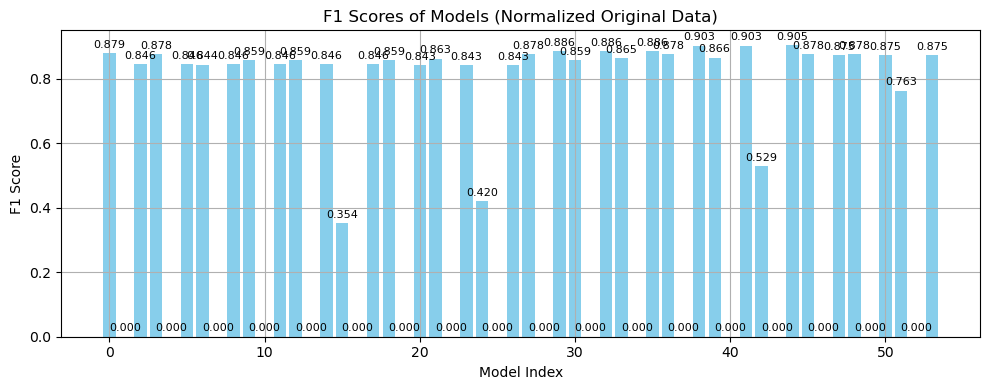

In [9]:
# === 6. Training on normalized data ===
print("# Training on normalized data")
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
import pandas as pd
import matplotlib.pyplot as plt

# Parameter grid
param_grid = {
    'hidden_layer_sizes': [(128, 64), (64, 32), (32, 16)],
    'activation': ['relu', 'tanh', ],
    'solver': ['adam', 'sgd','lbfgs'],
    'max_iter': [300, 200, 100],
    'random_state': [42]
}

# Model and cross-validation setup
clf_orig = MLPClassifier()
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Grid search with F1 scoring
grid_orig = GridSearchCV(
    clf_orig,
    param_grid,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
grid_orig.fit(X_norm, Y)

# Output results
print("Training on normalized original data completed.")
print("Best F1 Score (Normalized Unsorted Data):", round(grid_orig.best_score_, 4))
print("Best Model Parameters:")
for k, v in grid_orig.best_params_.items():
    print(f"   {k}: {v}")

# Calculate average accuracy using cross-validation
best_model_orig = grid_orig.best_estimator_
acc_scores = cross_val_score(best_model_orig, X_norm,Y, cv=cv, scoring='accuracy')
print("Average Accuracy (Cross-Validation):", round(acc_scores.mean(), 4))

# Visualize F1 scores of different models
results_orig = pd.DataFrame(grid_orig.cv_results_)

plt.figure(figsize=(10, 4))
bars = plt.bar(range(len(results_orig['mean_test_score'])), results_orig['mean_test_score'], color='skyblue')

plt.title("F1 Scores of Models (Normalized Original Data)")
plt.ylabel("F1 Score")
plt.xlabel("Model Index")
plt.grid(True)

# Add text labels on top of each bar
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 0.01,
             f'{bar.get_height():.3f}',
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

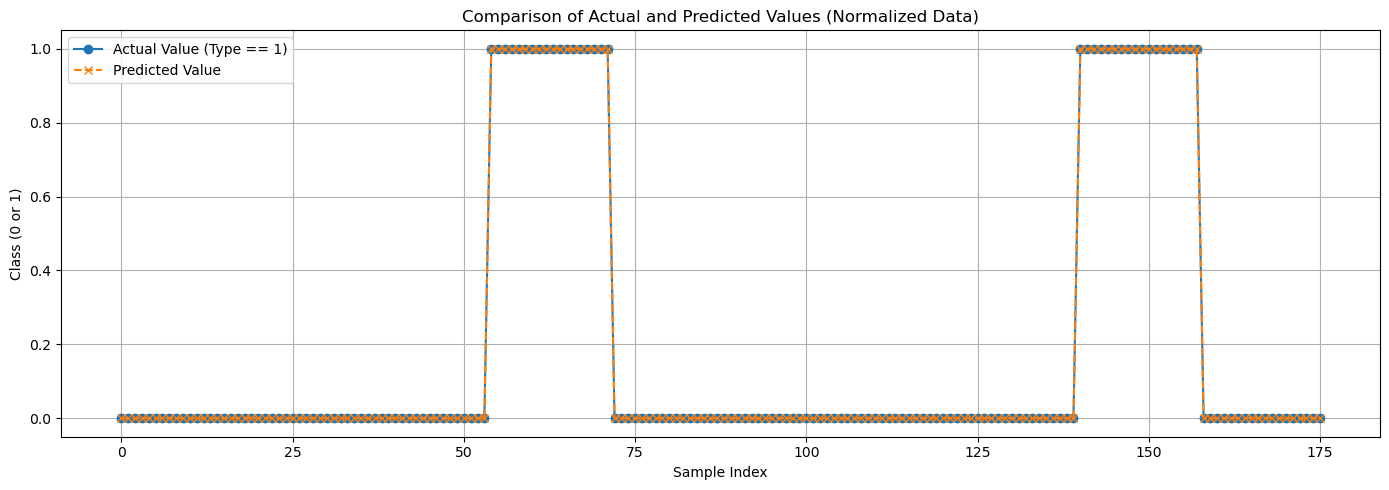

In [10]:
# Fit the best model from the original normalized data
model = grid_orig.best_estimator_
model.fit(X_norm, Y)
y_pred_orig = model.predict(X_norm)

# Get the total number of samples
N = len(Y)

# Plot the comparison of actual and predicted values (for normalized data)
plt.figure(figsize=(14, 5))
plt.plot(np.arange(N), Y, label='Actual Value (Type == 1)', marker='o')
plt.plot(np.arange(N), Y, label='Predicted Value', marker='x', linestyle='--')

# Plot settings
plt.title('Comparison of Actual and Predicted Values (Normalized Data)')
plt.xlabel('Sample Index')
plt.ylabel('Class (0 or 1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Fitting 4 folds for each of 54 candidates, totalling 216 fits
Training on normalized sorted data completed.
Best F1 Score (Normalized Sorted Data): 0.915
Best Model Parameters:
   activation: tanh
   hidden_layer_sizes: (128, 64)
   max_iter: 300
   random_state: 42
   solver: lbfgs
Average Accuracy (Cross-Validation): 0.9659


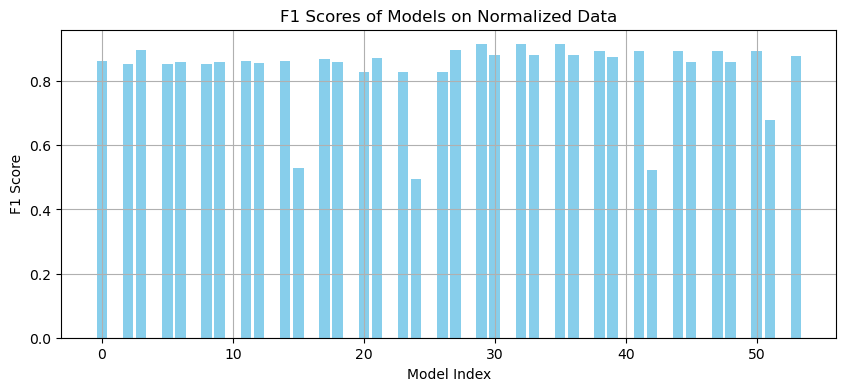

In [11]:
# 7. Normalize the sorted data using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# Normalize the features X_sort of the sorted data
scaler = MinMaxScaler()  # Initialize the normalizer
X_sorted_norm = scaler.fit_transform(X_sorted)  # Apply normalization to the sorted data


# Parameter grid
param_grid = {
    'hidden_layer_sizes': [(128, 64), (64, 32), (32, 16)],
    'activation': ['relu', 'tanh', ],
    'solver': ['adam', 'sgd','lbfgs'],
    'max_iter': [300, 200, 100],
    'random_state': [42]
}

# Initialize the classifier and cross-validation object
clf_norm = MLPClassifier()
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Perform grid search
grid_norm = GridSearchCV(
    clf_norm,
    param_grid,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_norm.fit(X_sorted_norm, Y_sorted)

# Output the training results
print("Training on normalized sorted data completed.")
print("Best F1 Score (Normalized Sorted Data):", round(grid_norm.best_score_, 4))
print("Best Model Parameters:")
for k, v in grid_norm.best_params_.items():
    print(f"   {k}: {v}")

# Calculate average accuracy using cross-validation
best_model_norm = grid_norm.best_estimator_
acc_scores = cross_val_score(best_model_norm, X_sorted_norm, Y_sorted, cv=cv, scoring='accuracy')
print("Average Accuracy (Cross-Validation):", round(acc_scores.mean(), 4))

# Retrieve the results from the grid search
results_norm = pd.DataFrame(grid_norm.cv_results_)

# Visualize the F1 scores of different models
plt.figure(figsize=(10, 4))
plt.bar(range(len(results_norm['mean_test_score'])), results_norm['mean_test_score'], color='skyblue')

plt.title("F1 Scores of Models on Normalized Data")
plt.ylabel("F1 Score")
plt.xlabel("Model Index")
plt.grid(True)
plt.show()

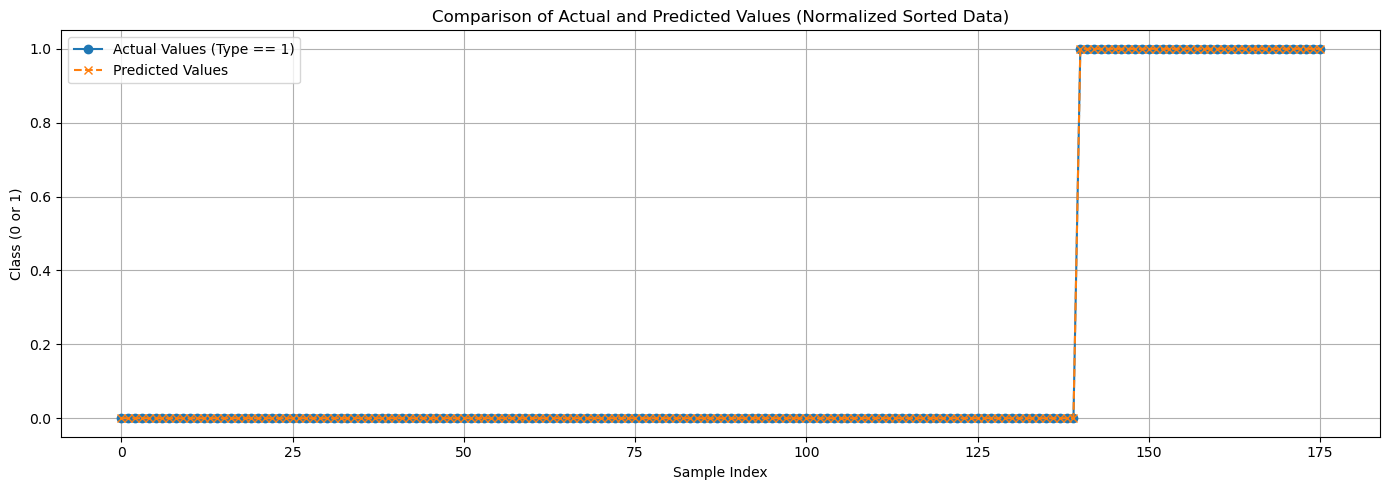

In [12]:
# Fit and predict using the best model from normalized data
model = grid_norm.best_estimator_  # Retrieve the best model
model.fit(X_sorted_norm, Y_sorted)     # Train the model on normalized sorted data
y_pred_sort = model.predict(X_sorted_norm)  # Make predictions

# Get the total number of samples
N = len(Y_sorted)

# Plot comparison of actual and predicted values (for normalized sorted data)
plt.figure(figsize=(14, 5))
plt.plot(np.arange(N), Y_sorted[:N], label='Actual Values (Type == 1)', marker='o')  # Blue dots
plt.plot(np.arange(N), y_pred_sort[:N], label='Predicted Values', marker='x', linestyle='--')  # Orange crosses

# Plot settings
plt.title('Comparison of Actual and Predicted Values (Normalized Sorted Data)')
plt.xlabel('Sample Index')  # Sample index
plt.ylabel('Class (0 or 1)')  # Class label
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Training with SMOTE balancing
Fitting 4 folds for each of 54 candidates, totalling 216 fits

Training on SMOTE-balanced data completed.
F1 Score (SMOTE): 0.9824
Best Model Parameters:
   activation: tanh
   hidden_layer_sizes: (32, 16)
   max_iter: 300
   random_state: 42
   solver: lbfgs
Cross-validated Accuracy: 0.9786


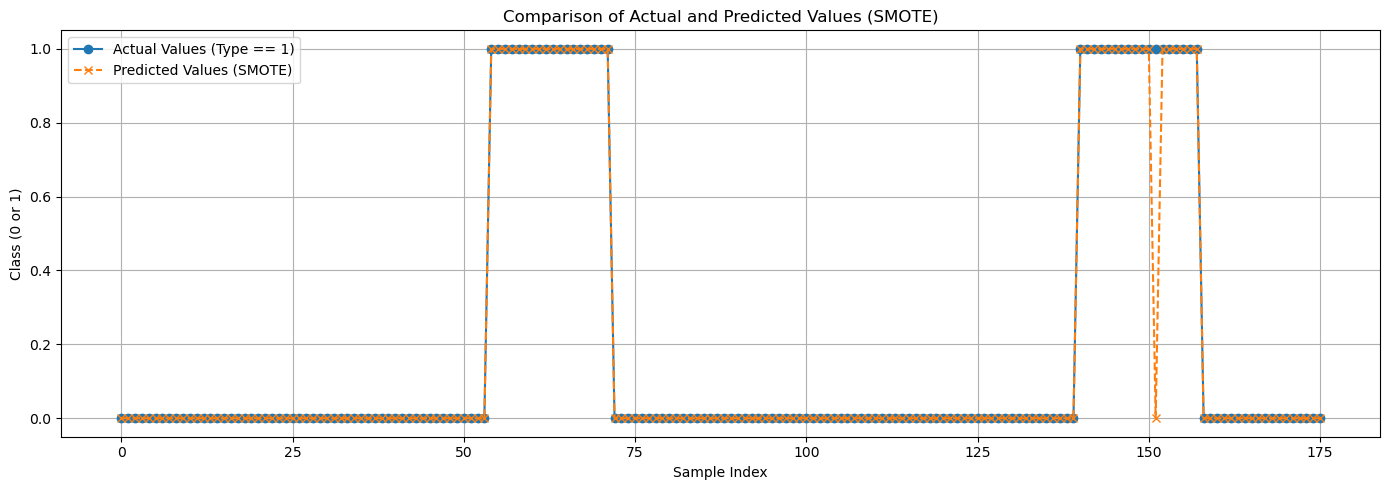

In [13]:
# === 7. Training with SMOTE balancing ===
print("# Training with SMOTE balancing")
smote = SMOTE(random_state=42, k_neighbors=1)
X_bal, Y_bal = smote.fit_resample(X_norm, Y)

# Parameter grid
param_grid = {
    'hidden_layer_sizes': [(128, 64), (64, 32), (32, 16)],
    'activation': ['relu', 'tanh', ],
    'solver': ['adam', 'sgd','lbfgs'],
    'max_iter': [300, 200, 100],
    'random_state': [42]
}


# Initialize the model and cross-validation object
clf = MLPClassifier()
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Perform GridSearchCV with F1 scoring
grid_sm = GridSearchCV(clf, param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=1)
grid_sm.fit(X_bal, Y_bal)

print("\nTraining on SMOTE-balanced data completed.")
print("F1 Score (SMOTE):", round(grid_sm.best_score_, 4))
print("Best Model Parameters:")
for k, v in grid_sm.best_params_.items():
    print(f"   {k}: {v}")

# Evaluate cross-validation accuracy
best_model_sm = grid_sm.best_estimator_
acc_scores_sm = cross_val_score(best_model_sm, X_bal, Y_bal, cv=cv, scoring='accuracy')
print("Cross-validated Accuracy:", round(acc_scores_sm.mean(), 4))

# Retrieve the best model and train it on the balanced data
best_model_sm = grid_sm.best_estimator_
best_model_sm.fit(X_bal, Y_bal)

# Make predictions on the original unbalanced normalized data (for visualization)
y_pred_sm = best_model_sm.predict(X_norm)
N = len(Y)

# Plot comparison: SMOTE
plt.figure(figsize=(14, 5))
plt.plot(np.arange(N), Y[:N], label='Actual Values (Type == 1)', marker='o')  # Actual values
plt.plot(np.arange(N), y_pred_sm[:N], label='Predicted Values (SMOTE)', marker='x', linestyle='--')  # Predicted values

plt.title('Comparison of Actual and Predicted Values (SMOTE)')
plt.xlabel('Sample Index')  # Sample index
plt.ylabel('Class (0 or 1)')  # Class label
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Training with TomekLinks balancing
Fitting 4 folds for each of 54 candidates, totalling 216 fits

Training on TomekLinks-balanced data completed.
F1 Score (TomekLinks): 0.9055
Best Model Parameters:
   activation: tanh
   hidden_layer_sizes: (64, 32)
   max_iter: 100
   random_state: 42
   solver: lbfgs
Cross-validated Accuracy (TomekLinks): 0.9602


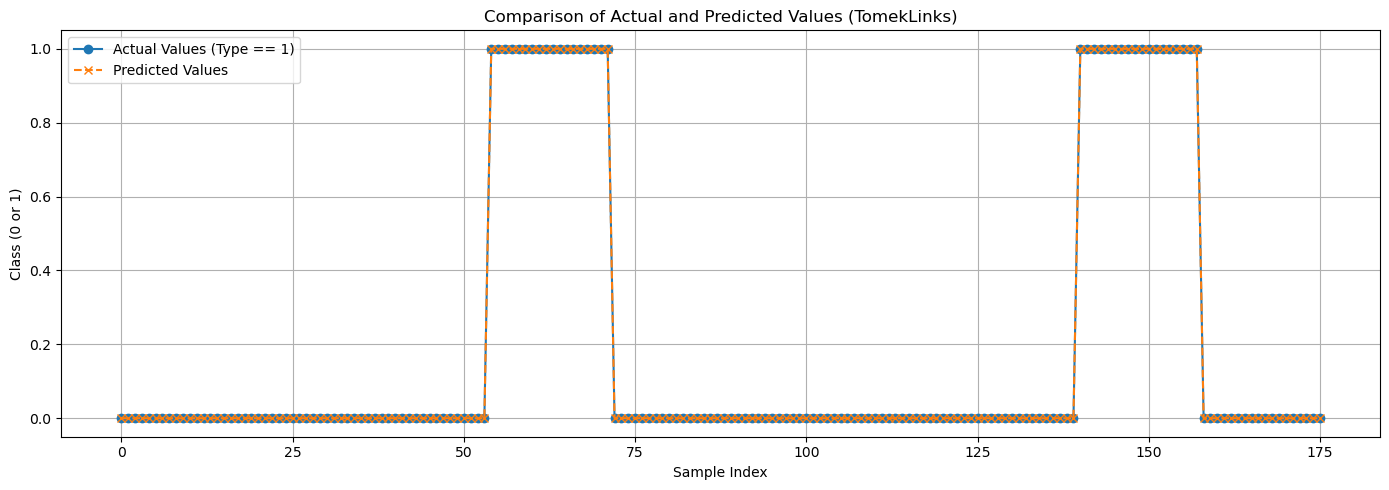

In [14]:
from imblearn.under_sampling import TomekLinks
print("# Training with TomekLinks balancing")
tomek = TomekLinks(sampling_strategy='all')  # 'all' means clean the boundary samples of all classes
X_tl, Y_tl = tomek.fit_resample(X_norm, Y)

# Perform GridSearchCV with F1 scoring
grid_ad = GridSearchCV(clf, param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=1)
grid_ad.fit(X_tl, Y_tl)

print("\nTraining on TomekLinks-balanced data completed.")
print("F1 Score (TomekLinks):", round(grid_ad.best_score_, 4))
print("Best Model Parameters:")
for k, v in grid_ad.best_params_.items():
    print(f"   {k}: {v}")

# Evaluate cross-validation accuracy
from sklearn.model_selection import cross_val_score

best_model_ad = grid_ad.best_estimator_
acc_scores_ad = cross_val_score(best_model_ad, X_tl, Y_tl, cv=cv, scoring='accuracy')
print("Cross-validated Accuracy (TomekLinks):", round(acc_scores_ad.mean(), 4))

# Retrieve the best model
model_ad = grid_ad.best_estimator_

# Train the model on ADASYN-balanced data
model_ad.fit(X_tl, Y_tl)

# Make predictions on the training set
y_pred_ad = model_ad.predict(X_tl)
N_ad = len(X_tl)

# Plot comparison of actual and predicted values (ADASYN)
plt.figure(figsize=(14, 5))
plt.plot(np.arange(N_ad), Y_tl[:N_ad], label='Actual Values (Type == 1)', marker='o')  # Blue dots
plt.plot(np.arange(N_ad), y_pred_ad[:N_ad], label='Predicted Values', marker='x', linestyle='--')  # Orange crosses

# Plot settings
plt.title('Comparison of Actual and Predicted Values (TomekLinks)')
plt.xlabel('Sample Index')
plt.ylabel('Class (0 or 1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
# === 8. Validate model generalization on test set C ===
print("# Validation on test set C")
X_test_norm = scaler.transform(X_test)

# Initialize the best model with specified parameters
best_model = MLPClassifier(
    hidden_layer_sizes=(32, 16),
    activation='relu',
    solver='adam',
    max_iter=300,
    random_state=42
)
best_model.fit(X_bal, Y_bal)  # Train using SMOTE-balanced data

# Make predictions on the control set
y_pred = best_model.predict(X_test_norm)

# Output Accuracy and F1 score
from sklearn.metrics import accuracy_score, f1_score, classification_report

print("Control Set C — Accuracy:", round(accuracy_score(Y_test, y_pred), 4))
print("Control Set C — F1 (weighted):", round(f1_score(Y_test, y_pred, average='weighted'), 4))

# Visualize the classification report
print("\nClassification Report:")
print(classification_report(Y_test, y_pred, digits=3))

# Validation on test set C
Control Set C — Accuracy: 0.9655
Control Set C — F1 (weighted): 0.9665

Classification Report:
              precision    recall  f1-score   support

           0      1.000     0.957     0.978        46
           1      0.857     1.000     0.923        12

    accuracy                          0.966        58
   macro avg      0.929     0.978     0.950        58
weighted avg      0.970     0.966     0.966        58



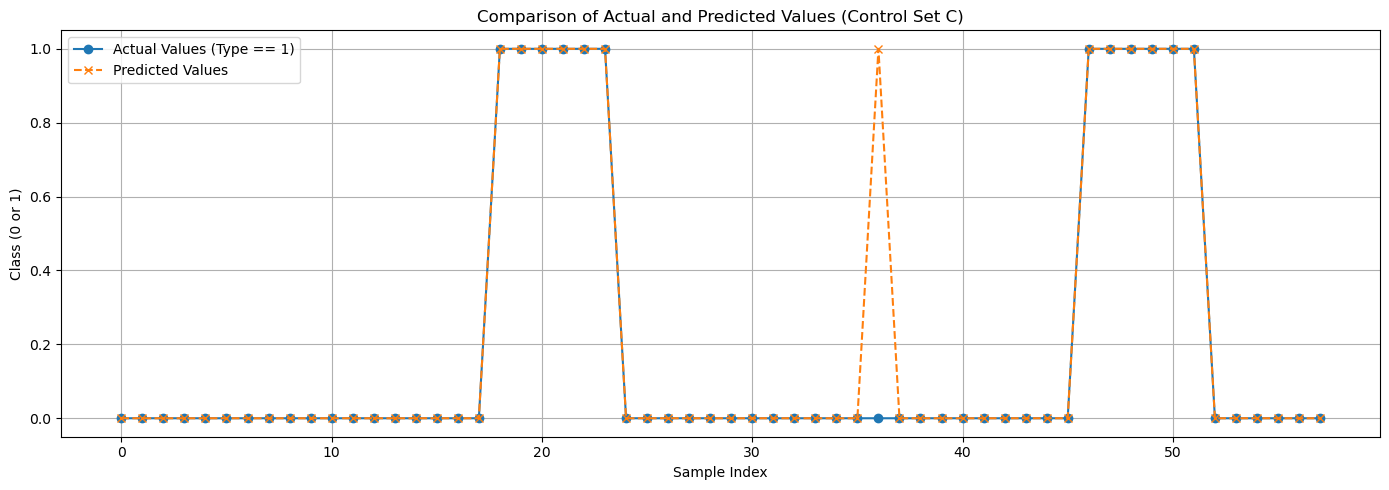

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Get the number of samples
N_C = len(Y_test)

# Plot comparison of actual and predicted values
plt.figure(figsize=(14, 5))

# Actual values (blue dots)
plt.plot(np.arange(N_C), Y_test.values[:N_C], label='Actual Values (Type == 1)', marker='o', linestyle='-')

# Predicted values (orange crosses)
plt.plot(np.arange(N_C), y_pred[:N_C], label='Predicted Values', marker='x', linestyle='--')

# Plot labels and formatting
plt.title('Comparison of Actual and Predicted Values (Control Set C)')
plt.xlabel('Sample Index')  # Sample index
plt.ylabel('Class (0 or 1)')  # Class label
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

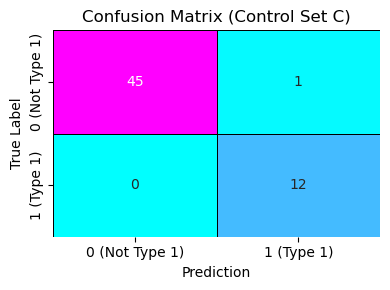

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Build a comparison DataFrame
df_eval = pd.DataFrame({
    "True Label": Y_test,
    "Prediction": y_pred
})

# Confusion Matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(4, 3))
# Use Seaborn's heatmap with a light gray background
sns.heatmap(cm, annot=True, fmt='d', cmap='cool',
            xticklabels=["0 (Not Type 1)", "1 (Type 1)"],
            yticklabels=["0 (Not Type 1)", "1 (Type 1)"],
            linewidths=0.5, linecolor='black',  # Add grid lines for better readability
            cbar=False)  # Disable color bar for cleaner look

# Set the background color to light gray
plt.gca().set_facecolor('#f0f0f0')  # Light gray background

plt.title("Confusion Matrix (Control Set C)")
plt.xlabel("Prediction")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

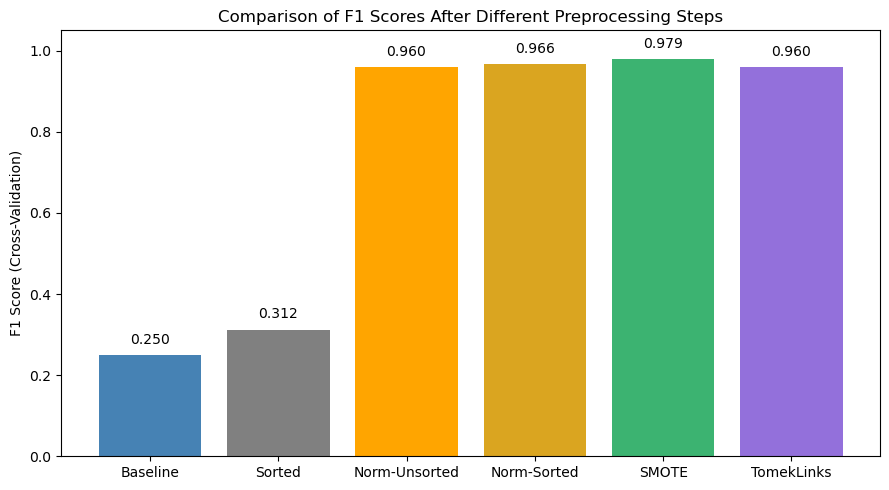

In [57]:
import matplotlib.pyplot as plt

# F1 scores for six different stages (replace with your actual results)
f1_baseline   = 0.25   # Original data (Baseline)
f1_sorted     = 0.3125    # Sorted only
f1_norm_un    = 0.9602    # Normalized (Unsorted)
f1_norm_sort  = 0.9659   # Normalized (Sorted)
f1_smote      = 0.9786   # SMOTE (based on Norm-Unsorted)
f1_TomekLinks     = 0.9602   # ADASYN (based on Norm-Unsorted)

labels = ['Baseline', 'Sorted', 'Norm-Unsorted', 'Norm-Sorted', 'SMOTE', 'TomekLinks']
scores = [f1_baseline, f1_sorted, f1_norm_un, f1_norm_sort, f1_smote, f1_TomekLinks]
colors = ['steelblue', 'gray', 'orange', 'goldenrod', 'mediumseagreen', 'mediumpurple']

# Plotting
plt.figure(figsize=(9, 5))
bars = plt.bar(labels, scores, color=colors)
plt.ylim(0, 1.05)
plt.ylabel('F1 Score (Cross-Validation)')
plt.title('Comparison of F1 Scores After Different Preprocessing Steps')

# Adding value labels
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2,
             score + 0.02,
             f'{score:.3f}',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()